# Day 7

This year, Santa brought little Bobby Tables a set of wires and bitwise logic gates! Unfortunately, little Bobby is a little under the recommended age range, and he needs help assembling the circuit.

Each wire has an identifier (some lowercase letters) and can carry a 16-bit signal (a number from 0 to 65535). A signal is provided to each wire by a gate, another wire, or some specific value. Each wire can only get a signal from one source, but can provide its signal to multiple destinations. A gate provides no signal until all of its inputs have a signal.

The included instructions booklet describes how to connect the parts together: x AND y -> z means to connect wires x and y to an AND gate, and then connect its output to wire z.

For example:

    123 -> x means that the signal 123 is provided to wire x.
    x AND y -> z means that the bitwise AND of wire x and wire y is provided to wire z.
    p LSHIFT 2 -> q means that the value from wire p is left-shifted by 2 and then provided to wire q.
    NOT e -> f means that the bitwise complement of the value from wire e is provided to wire f.

Other possible gates include OR (bitwise OR) and RSHIFT (right-shift). If, for some reason, you'd like to emulate the circuit instead, almost all programming languages (for example, C, JavaScript, or Python) provide operators for these gates.

For example, here is a simple circuit:

```text
123 -> x
456 -> y
x AND y -> d
x OR y -> e
x LSHIFT 2 -> f
y RSHIFT 2 -> g
NOT x -> h
NOT y -> i
```

After it is run, these are the signals on the wires:

```text
d: 72
e: 507
f: 492
g: 114
h: 65412
i: 65079
x: 123
y: 456
```

In little Bobby's kit's instructions booklet (provided as your puzzle input), what signal is ultimately provided to wire `a`?

## Puzzle 1

In [1]:
import matplotlib.pyplot as plt
import networkx as nx

from typing import Tuple


class Circuit():
    
    def __init__(self):
        self.clear_circuit()
                
    def clear_circuit(self):
        """Initialise circuit"""
        self._circuit = nx.DiGraph()
        
    def add_wire(self, instr:str):
        """Add new wire to circuit
        
        :param instr: instruction for connecting wire
        
        The instruction has two parts, separated by ` -> `.
        
        RHS: output destination
        LHS: input wires, possibly with bitwise operators, or
             an integer (to be interpreted as a 16-bit binary
             value)
        """
        lhs, rhs = instr.strip().split(" -> ")
        
        # If output wire doesn't exist, add it
        if rhs not in self._circuit.nodes:
            self._circuit.add_node(rhs)

        try: # Node is an input
            nx.set_node_attributes(self._circuit, {rhs: {"val": int(lhs) & 0xFFFF}})
        except ValueError:  # node is not an input
            # Parse LHS and update graph
            self.parse_lhs(lhs, rhs)
        
    def parse_lhs(self, lhs:str, rhs:str):
        """Parse LHS and update graph
        
        :param lhs: definition for LHS of wire addition
        :param rhs: definition for RHS of wire addition
        """
        # Set node instruction text
        nx.set_node_attributes(self._circuit, {rhs: {"instr": lhs}})
        
        # Add edges to circuit
        if "NOT" in lhs:
            _, node = lhs.split()
            self._circuit.add_edge(node, rhs)
        elif "SHIFT" in lhs:
            node, op, val = lhs.split()
            self._circuit.add_edge(node, rhs)
        elif ("AND" in lhs) or ("OR" in lhs):
            node1, op, node2 = lhs.split()
            try:
                int(node1)
            except ValueError:
                self._circuit.add_edge(node1, rhs)
            try:
                int(node2)
            except ValueError:
                self._circuit.add_edge(node2, rhs)
        else:  # no operation
            self._circuit.add_edge(lhs, rhs)
            
    def calculate(self):
        """Calculate outputs at each wire/node
        
        We create two lists: nodes with no value, and nodes with a 
        value attribute.
        
        We identify nodes with no value where the input node(s) do
        have a value. For these nodes we use the rule in the instr
        attribute to calculate a value and transfer the node to the
        list of nodes with values.
        
        We continue until the list of nodes with no value is empty.
        """
        vals = [_ for _ in self._circuit.nodes(data=True) if "val" in _[1]]
        novals = [_ for _ in self._circuit.nodes(data=True) if "val" not in _[1]]
        
        while len(novals):
            node = novals.pop(0)
            in_edges = self.__in_wires(node[0])
            if all([_ in [n[0] for n in vals] for _ in in_edges]):  # All input values ready
                self.__calculate_node_val(node)
                vals.append(node)
            else:  # Input values not ready, cycle round again
                calculate = False
                novals.append(node)

    def set_node_val(self, node:str, val:int):
        """Set a node value directly
        
        :param node: node label
        :param val: value for node
        """
        nx.set_node_attributes(self._circuit, {node: {"val": int(val) & 0xFFFF}})
        
    def __calculate_node_val(self, node:Tuple):
        """Calculate value for passed node
        
        :param node: (node_label, {data values})
        """
        instr = node[1]["instr"]  # instruction for calculation
        if "NOT" in instr:
            inp = self._circuit.nodes()[instr.strip().split()[-1]]
            nx.set_node_attributes(self._circuit, {node[0]: {"val": ~inp["val"] & 0xFFFF}})
        elif "AND" in instr:
            inp1, opn, inp2 = instr.strip().split()
            try:
                inp1 = self._circuit.nodes()[inp1]
            except KeyError:
                inp1 = {"val": int(inp1)}
            try:
                inp2 = self._circuit.nodes()[inp2]
            except KeyError:
                inp2 = {"val": int(inp2)}
            nx.set_node_attributes(self._circuit, {node[0]: {"val": inp1["val"] & inp2["val"] & 0xFFFF}})
        elif "OR" in instr:
            inp1, opn, inp2 = instr.strip().split()
            try:
                inp1 = self._circuit.nodes()[inp1]
            except KeyError:
                inp1 = {"val": int(inp1)}
            try:
                inp2 = self._circuit.nodes()[inp2]
            except KeyError:
                inp2 = {"val": int(inp2)}
            nx.set_node_attributes(self._circuit, {node[0]: {"val": inp1["val"] | inp2["val"] & 0xFFFF}})
        elif "LSHIFT" in instr:
            inp1, opn, val = instr.strip().split()
            inp1, val = self._circuit.nodes()[inp1], int(val)
            nx.set_node_attributes(self._circuit, {node[0]: {"val": (inp1["val"] << val) & 0xFFFF}})
        elif "RSHIFT" in instr:
            inp1, opn, val = instr.strip().split()
            inp1, val = self._circuit.nodes()[inp1], int(val)
            nx.set_node_attributes(self._circuit, {node[0]: {"val": (inp1["val"] >> val) & 0xFFFF}})
        else:
            inp1 = self._circuit.nodes()[instr.strip()]
            nx.set_node_attributes(self._circuit, {node[0]: {"val": inp1["val"] & 0xFFFF}})
        
    def __in_wires(self, node:str):
        """Return the labels of wires passing values into the node
        
        :param node: node label
        """
        return [_[0] for _ in self._circuit.in_edges(node)]
        
    @property
    def circuit(self):
        """Return circuit (copy)"""
        return self._circuit.copy()
    
    @property
    def node_values(self):
        """Return sorted node values"""
        return sorted(self.circuit.nodes(data="val"))

In [2]:
instrs = ("123 -> x",
          "456 -> y",
          "x AND y -> d",
          "x OR y -> e",
          "x LSHIFT 2 -> f",
          "y RSHIFT 2 -> g",
          "NOT x -> h",
          "NOT y -> i")

circuit = Circuit()
for instr in instrs:
    circuit.add_wire(instr)
circuit.calculate()
circuit.node_values

[('d', 72),
 ('e', 507),
 ('f', 492),
 ('g', 114),
 ('h', 65412),
 ('i', 65079),
 ('x', 123),
 ('y', 456)]

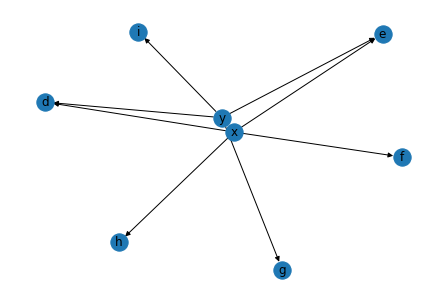

In [3]:
nx.draw(circuit.circuit, with_labels=True)

### Solution

In [4]:
circuit = Circuit()
with open("day07.txt", "r") as ifh:
    for instr in [_.strip() for _ in ifh.readlines()]:
        circuit.add_wire(instr)
circuit.calculate()
circuit.circuit.nodes()["a"]  

{'instr': 'lx', 'val': 956}

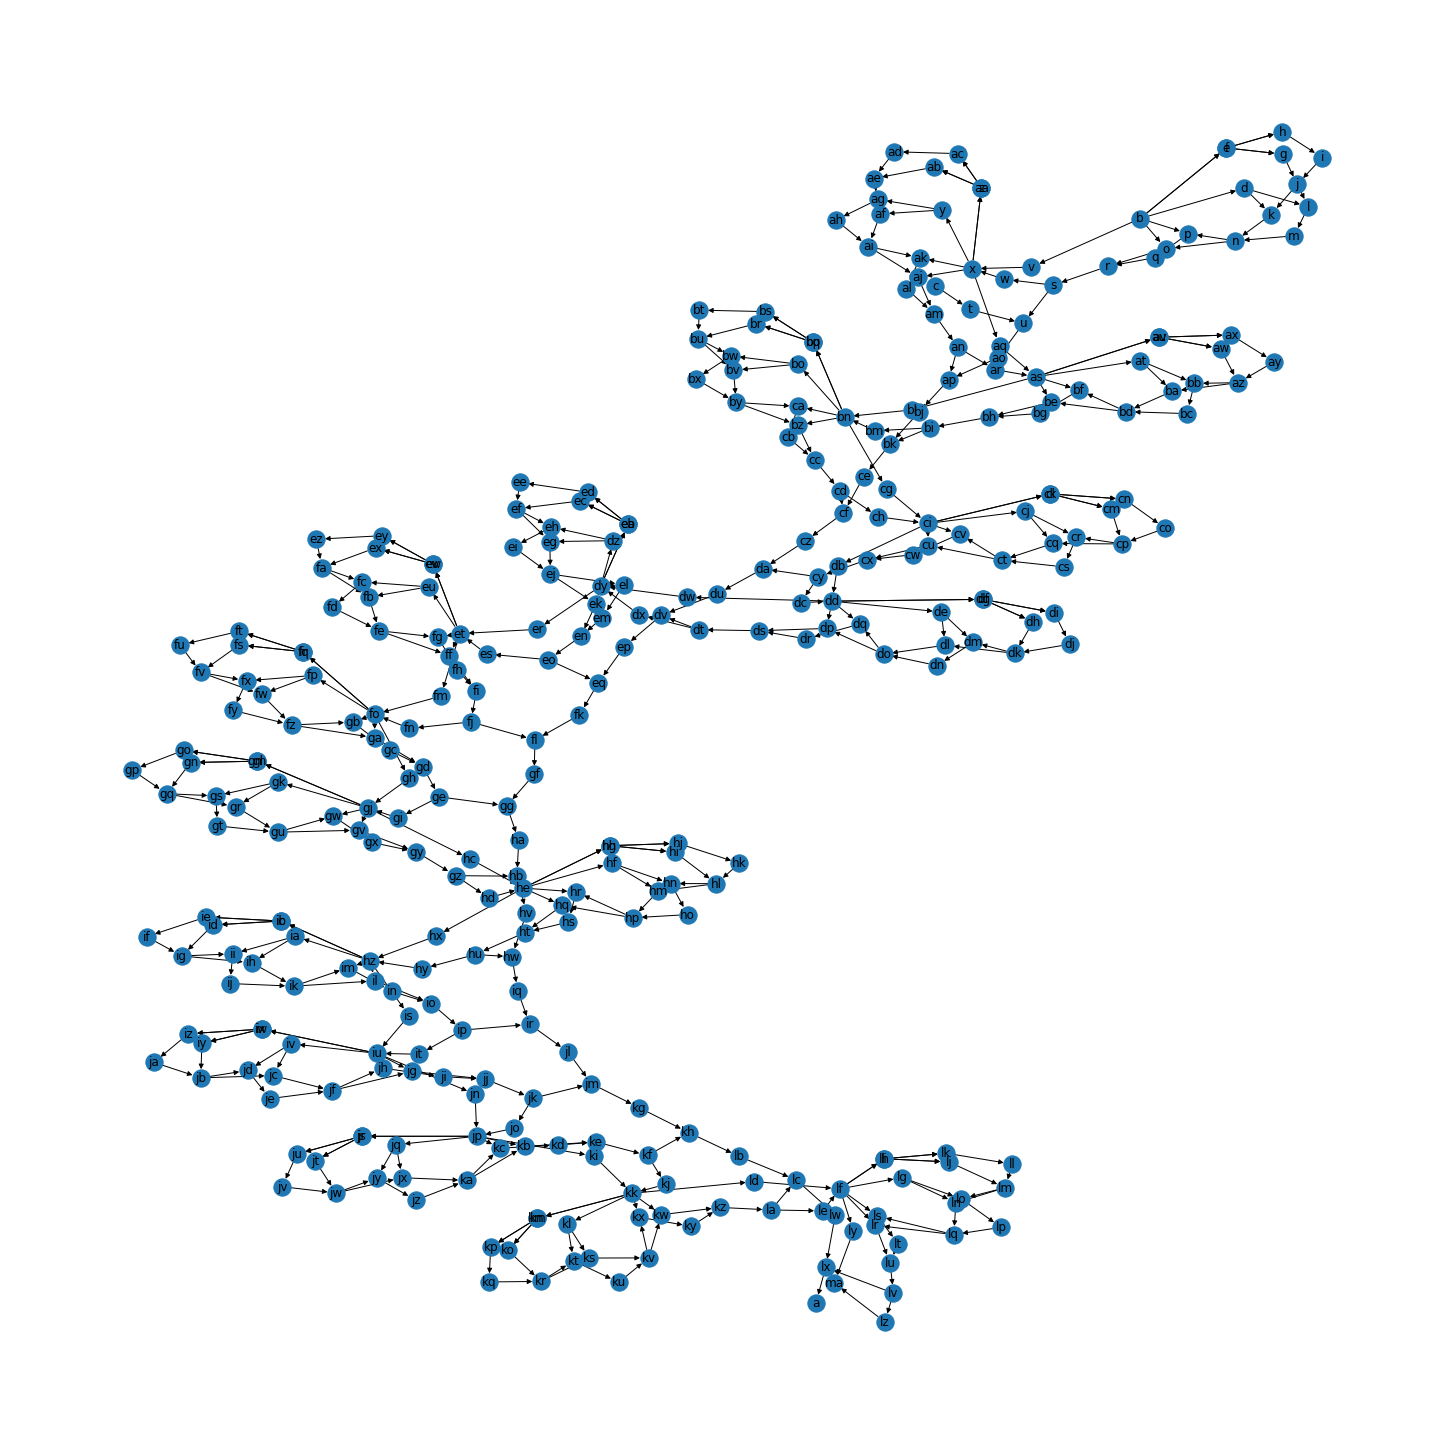

In [5]:
plt.figure(figsize=(20, 20))
nx.draw_kamada_kawai(circuit.circuit, with_labels=True)

## Puzzle 2

Now, take the signal you got on wire `a`, override wire `b` to that signal, and reset the other wires (including wire `a`). What new signal is ultimately provided to wire `a`?

### Solution

In [6]:
circuit = Circuit()
with open("day07.txt", "r") as ifh:
    for instr in [_.strip() for _ in ifh.readlines()]:
        circuit.add_wire(instr)
circuit.set_node_val("b", 956)
circuit.calculate()
circuit.circuit.nodes()["a"]  

{'instr': 'lx', 'val': 40149}